In [291]:
%matplotlib notebook

import strawb
import pandas 

import glob
import numpy as np
from matplotlib import pyplot as plt

import math

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import poisson
import scipy.constants as const
from scipy import ndimage

from numpy.polynomial import polynomial as P

width  = 9.5
height = width / 1.618
figsize = np.array((width,height))

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

import datetime

# set plotly default to plotly_white and define a presonal colorway
pio.templates["myname"] = go.layout.Template(
    layout=go.Layout(
        colorway=px.colors.qualitative.T10,  # colors
        yaxis = dict(exponentformat = 'SI'),  # exponentformat to SI, i.e., 1e9 -> 1G
    ))
pio.templates.default = "plotly_white+myname"  # 'plotly_white' and overwrite with the pramters in 'myname'

# Get Starting time
1. get sdaq file of the day
2. get lidar.daq_frequency_pmt
3. get startingtime of it. Marks the beginning of an measurement
4. get my scan and use it to cut

In [846]:
 file_list = strawb.sensors.lidar.FileHandler.find_files('TUMLIDAR001_20210914T000000.000Z-SDAQ-LIDAR.hdf5',
                                               directory=strawb.Config.raw_data_dir,
                                               recursive=True,
                                               raise_nothing_found=True)

In [847]:
lidar = strawb.sensors.lidar.FileHandler(file_list[0])
lidar.file_attributes  # show the file attributes, time in seconds since epoch (1.1.1970) UTC

{'dev_code': 'TUMLIDAR001',
 'file_end': 1631663999.999,
 'file_id': 17776833060962709053,
 'file_start': 1631577600.0,
 'following_file_id': 12589622114735664389,
 'name': 'LIDAR',
 'previous_file_id': 8954152542778969461,
 'rollover_interval': "{'days': 1}",
 'run_end': nan,
 'run_start': 1631577100.067628,
 'write_period': 60.0}

In [848]:
df_daq = pandas.DataFrame(dict(time = lidar.daq_time.asdatetime()[:],
                               frequency_pmt = lidar.daq_frequency_pmt,
                               frequency_trigger = lidar.daq_frequency_trigger,
                               pmt = lidar.daq_pmt,
                               pulser_readout = lidar.daq_pulser_readout,
                               pulser_trigger = lidar.daq_pulser_trigger,
                               state = lidar.daq_state,
                               trb = lidar.daq_trb))

In [849]:
#df_daq

In [850]:
df_gimbal = pandas.DataFrame(dict(time = lidar.gimbal_time.asdatetime()[:],
                                  delay = lidar.gimbal_delay,
                                  pos_x = lidar.gimbal_pos_x,
                                  pos_y = lidar.gimbal_pos_y,
                                  power = lidar.gimbal_power,)
                         )

In [851]:
#df_gimbal

In [852]:
df_laser = pandas.DataFrame(dict(time = lidar.laser_time.asdatetime()[:],
                                 diode = lidar.laser_diode,
                                 frequency = lidar.laser_frequency,
                                 power = lidar.laser_power,
                                 pulsewidth = lidar.laser_pulsewidth,
                                 set_adjust_x = lidar.laser_set_adjust_x,
                                 set_adjust_y = lidar.laser_set_adjust_y,)
                          )

In [853]:
#df_laser

## 1. define time mask 
- define a mask where changes in adjust_x and adjust_y happend
- for changes in adjust_x insert another boundary in the beginning to account for the first measurement at (0,0)
-> This is done by inserting the difference between 2nd and 3rd value, because from 1st to 2nd a change in y is also included. Therefore the difference in steps is twice as large!
- from min and max (always look which of the to gives the min and which the max) get whole measurement range
- for all indices in this range look if it is part of changes_adjust_x/y. If yes, append the time to time_mask
- (take care of index shift!)

## 2. get frequency
- Time_mask gives start and stop values for the measurement times. Technically it is to broad, but 'frequency_pmt' will anyway be zero outside the real measurement time
- loop through it, define for every time a mintime and maxtime and sum up the frequency of the pmt
- multiply frequency (in Units 1/s) with the time difference in this time frame to get "counts" (Not the real counts, since the time frame is larger than the real measurement, but since it is probably comparable larger for all time frames, it doesn't matter since it is a constant offset for all measurements)

In [884]:
changes_adjust_x = np.where(np.diff(df_laser['set_adjust_x']))[0] #zero element gives idices
changes_adjust_x = np.insert(changes_adjust_x, 0, changes_adjust_x[0] - np.diff(changes_adjust_x[1:3]))
changes_adjust_y = np.where(np.diff(df_laser['set_adjust_y']))[0]

measurement_range = df_laser[np.min(changes_adjust_x):np.max(changes_adjust_y) + 3] #+2: diff reduces by 1 and start at 0


In [885]:
len(changes_adjust_x)

311

In [886]:
time_mask = []
index_shift = np.min(changes_adjust_x)
changes = []
for i in measurement_range.index:
    if np.any(changes_adjust_x == i) or np.any(changes_adjust_y ==i):
        time_mask.append(measurement_range.iloc[i - index_shift]["time"])
        changes.append((measurement_range.iloc[i - index_shift]["set_adjust_x"], measurement_range.iloc[i - index_shift]["set_adjust_y"]))
        
time_mask_diff = []
for i in range(len(time_mask[:-1])):
    time_mask_diff.append((time_mask[i+1] - time_mask[i]))
    
convert_to_seconds = np.vectorize(lambda x: x.total_seconds())
time_diff_seconds = convert_to_seconds(time_mask_diff)

In [887]:
pmt_freq = np.zeros(len(time_mask) - 1)
for i in range(len(time_mask) - 1):
    mintime = time_mask[i]
    maxtime = time_mask[i+1]
    time_diff = maxtime - mintime
    time_diff = time_diff.total_seconds()
    mask_freq = (df_daq["time"] > mintime) & (df_daq["time"] < maxtime)
    pmt_freq[i] = np.sum(df_daq[mask_freq]['frequency_pmt']) #/ time_diff

#pmt_freq = pmt_freq / time_diff_seconds

In [896]:
pmt_freq[:np.where(pmt_freq == 0)[0][0]]

array([58791.5390625 , 54134.046875  , 69077.703125  , 55954.9765625 ,
       58754.8125    , 66517.578125  , 61848.3359375 , 60523.1875    ,
       54533.50390625, 71109.6015625 , 57993.59375   , 35222.828125  ,
       39556.0234375 , 39490.4296875 , 46332.15234375, 46418.203125  ,
       44942.5       , 66165.421875  , 69186.5390625 , 66076.1953125 ,
       56991.9375    , 54364.140625  , 48181.12109375, 45519.921875  ,
       43703.8203125 , 36705.5859375 , 49346.34375   , 51795.234375  ,
       52253.96875   , 43813.078125  , 26084.46679688, 26496.02734375,
       24147.16796875, 29657.29882812, 31969.22265625, 31497.546875  ,
       33271.21875   , 51032.53125   , 69166.765625  , 68765.4921875 ,
       65603.3828125 , 56264.375     , 49229.65234375, 49054.5078125 ,
       44739.03515625, 41339.6015625 , 38377.5546875 , 35577.48046875,
       29857.03125   , 31692.7421875 , 25178.1640625 , 38012.171875  ,
       39030.62890625, 44841.11328125, 36586.7109375 , 17400.88867188,
      

In [888]:
#------Changes values that are by far to high. Check first, if needed------#
#pmt_freq[np.where(pmt_freq>1e4)] = pmt_freq[np.where(pmt_freq>1e4)[0] + len(np.where(pmt_freq>1e4)[0])]

## 3. convert to spiral

- Convert the pmt_freq array into a spiral array

In [898]:
def spiral(steps_x, steps_y):
    X = steps_x*2 + 1
    Y = steps_y*2 + 1
    steps = np.zeros((X*Y,2))
    x = y = 0
    dx = 0
    dy = -1
    for i in range(max(X, Y)**2):
        if (-X/2 < x <= X/2) and (-Y/2 < y <= Y/2):
            #print (x, y)
            steps[i] = (x,y)
        if x == y or (x < 0 and x == -y) or (x > 0 and x == 1-y):
            dx, dy = -dy, dx
        x, y = x+dx, y+dy
    return steps


In [899]:
length = int(np.sqrt(len(pmt_freq[:121])))

length = np.sqrt(len(pmt_freq[:np.where(pmt_freq == 0)[0][0]]))
    
if not length%1 == 0:
    raise TypeError(f'{length} is not an integer represented as float. Check manually if mask of changes in laser adjustment was set correctly.')
length = int(length)
    
steps = int((length-1)/2)
pmt_freq_img = np.zeros((length, length))

indices = spiral(steps,steps)
shift = np.ceil((np.sqrt(len(indices))-1)/2)
indices_shifted = indices + shift

for i  in range(len(indices_shifted)):
    ii = int(indices_shifted[i,0])
    jj = int(indices_shifted[i,1])
    pmt_freq_img[ii,jj] = pmt_freq[i]

<IPython.core.display.Javascript object>


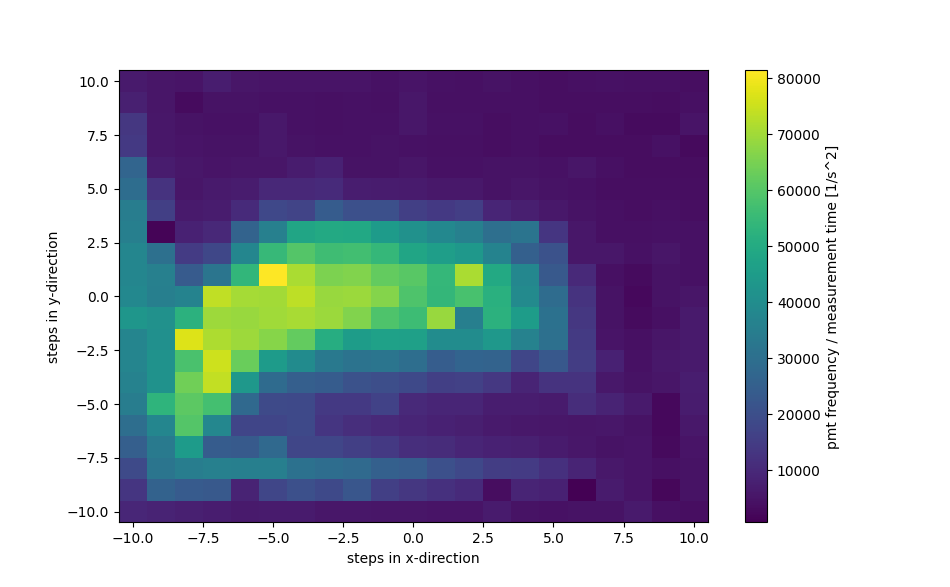

In [901]:
fig = plt.figure(figsize=figsize)

pmt_freq_img_90 = ndimage.rotate(pmt_freq_img, 90, reshape=False) #rotation because b

#plt.imshow(img_90, cmap='gray', extent=(-steps,steps,-steps,steps))
x = np.linspace(-steps-0.5,steps+0.5, (steps + 1) * 2, endpoint=True)

plt.pcolormesh(x,x,pmt_freq_img_90)
plt.xlabel('steps in x-direction')
plt.ylabel('steps in y-direction')
cbar = plt.colorbar()

cbar.set_label('pmt frequency / measurement time [1/s^2]')
#plt.savefig("laser_adjust_ratio_lidar2.png")
plt.show()


<IPython.core.display.Javascript object>


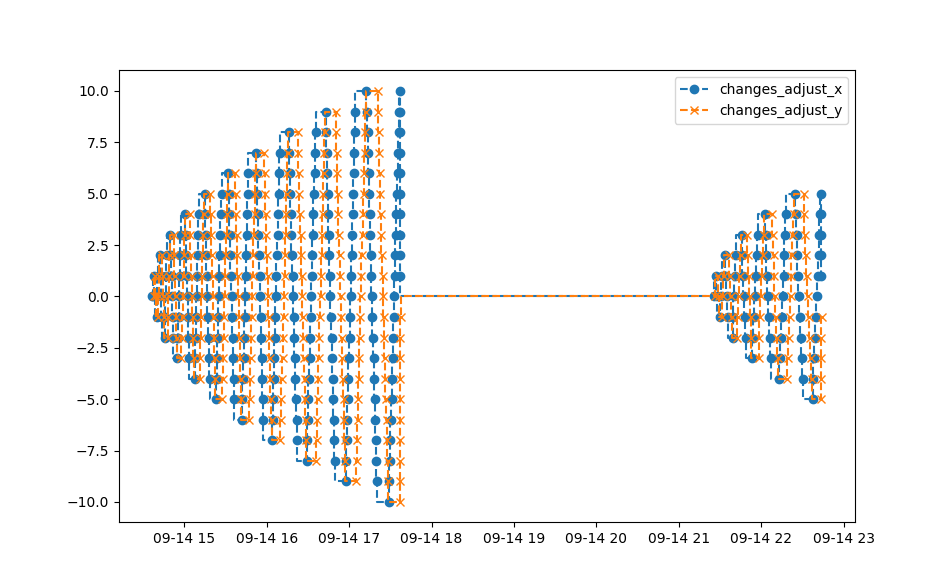

In [872]:
est = df_laser.iloc[changes_adjust_x]#['time']
test2 = df_laser.iloc[changes_adjust_y]#['time']
plt.figure(figsize=figsize)
#plt.step(measurement_range['time'], measurement_range['set_adjust_x'], "x--", label='set_adjust_x')
plt.step(test['time'], test['set_adjust_x'], "o--", label='changes_adjust_x')
#plt.step(measurement_range['time'], measurement_range['set_adjust_y'], "x--", label='set_adjust_y')
plt.step(test2['time'], test2['set_adjust_y'], "x--", label='changes_adjust_y')

plt.legend()
plt.show()

In [879]:
def laser_adjustment(file):
    lidar = strawb.sensors.lidar.FileHandler(file[0])
    df_daq = pandas.DataFrame(dict(time = lidar.daq_time.asdatetime()[:],
                               frequency_pmt = lidar.daq_frequency_pmt,
                               frequency_trigger = lidar.daq_frequency_trigger,
                               pmt = lidar.daq_pmt,
                               pulser_readout = lidar.daq_pulser_readout,
                               pulser_trigger = lidar.daq_pulser_trigger,
                               state = lidar.daq_state,
                               trb = lidar.daq_trb))
    df_laser = pandas.DataFrame(dict(time = lidar.laser_time.asdatetime()[:],
                                 diode = lidar.laser_diode,
                                 frequency = lidar.laser_frequency,
                                 power = lidar.laser_power,
                                 pulsewidth = lidar.laser_pulsewidth,
                                 set_adjust_x = lidar.laser_set_adjust_x,
                                 set_adjust_y = lidar.laser_set_adjust_y,))
    
    changes_adjust_x = np.where(np.diff(df_laser['set_adjust_x']))[0] #zero element gives idices
    changes_adjust_x = np.insert(changes_adjust_x, 0, changes_adjust_x[0] - np.diff(changes_adjust_x[1:3]))
    changes_adjust_y = np.where(np.diff(df_laser['set_adjust_y']))[0]
    measurement_range = df_laser[np.min(changes_adjust_x):np.max(changes_adjust_y) + 2] #+2: diff reduces by 1 and start at 0

    time_mask = []
    index_shift = np.min(changes_adjust_x)

    for i in measurement_range.index:
        if np.any(changes_adjust_x == i) or np.any(changes_adjust_y ==i):
            time_mask.append(measurement_range.iloc[i - index_shift]["time"])
    
    pmt_freq = np.zeros(len(time_mask) - 1)
    for i in range(len(time_mask) - 1):
        mintime = time_mask[i]
        maxtime = time_mask[i+1]
        time_diff = maxtime - mintime
        time_diff = time_diff.total_seconds()
        mask_freq = (df_daq["time"] > mintime) & (df_daq["time"] < maxtime)
        pmt_freq[i] = np.sum(df_daq[mask_freq]['frequency_pmt'])# / time_diff
        
    #------Changes values that are by far to high. Check first, if needed------#
    #pmt_freq[np.where(pmt_freq>1e4)] = pmt_freq[np.where(pmt_freq>1e4)[0] + len(np.where(pmt_freq>1e4)[0])]
    length = np.sqrt(len(pmt_freq[np.where(pmt_freq>0)]))
    
    if not length%1 == 0:
        raise TypeError(f'{length} is not an integer represented as float. Check manually if mask of changes in laser adjustment was set correctly.')
    length = int(length)
    steps = int((length-1)/2)
    pmt_freq_img = np.zeros((length, length))

    indices = spiral(steps,steps)
    shift = np.ceil((np.sqrt(len(indices))-1)/2)
    indices_shifted = indices + shift

    for i  in range(len(indices_shifted)):
        ii = int(indices_shifted[i,0])
        jj = int(indices_shifted[i,1])
        pmt_freq_img[ii,jj] = pmt_freq[i]
        
    return pmt_freq_img, steps

<IPython.core.display.Javascript object>


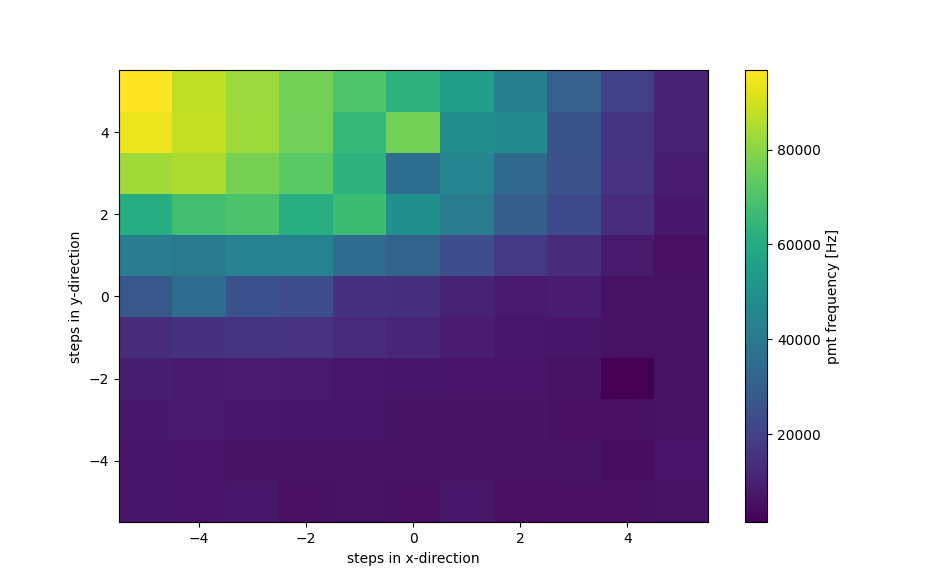

In [883]:
fig = plt.figure(figsize=figsize)
file = strawb.sensors.lidar.FileHandler.find_files('TUMLIDAR001_20210916T000000.000Z-SDAQ-LIDAR.hdf5',
                                               directory=strawb.Config.raw_data_dir,
                                               recursive=True,
                                               raise_nothing_found=True)

img,steps = laser_adjustment(file)

#pmt_freq_img_90 = ndimage.rotate(img, 0, reshape=False) #rotation because b

#plt.imshow(img_90, cmap='gray', extent=(-steps,steps,-steps,steps))
x = np.linspace(-steps-0.5,steps+0.5, (steps + 1) * 2, endpoint=True)

plt.pcolormesh(x,x,img.T)
plt.xlabel('steps in x-direction')
plt.ylabel('steps in y-direction')
cbar = plt.colorbar()

#cbar.set_label('pmt frequency / measurement time [1/s^2]')
cbar.set_label('pmt frequency [Hz]')

#plt.savefig("laser_adjust_ratio_lidar2.png")
plt.show()

In [767]:
mask = (df_laser['time'] > np.min(df_laser[df_laser['set_adjust_x'] != 0]['time'])) & (df_laser['time'] < np.max(df_laser[df_laser['set_adjust_x'] != 0]['time']))
mask = (df_laser['time'] > np.min(df_laser[df_laser['set_adjust_x'] != 0]['time'])) & (df_laser['time'] < np.max(df_laser[df_laser['set_adjust_x'] != 0]['time']))
mask2 = (df_laser['time'] > np.min(df_laser[df_laser['set_adjust_y'] != 0]['time'])) & (df_laser['time'] < np.max(df_laser[df_laser['set_adjust_y'] != 0]['time']))


In [ ]:
mintime = np.min(df_laser[df_laser['set_adjust_y'] != 0]['time'])
maxtime = np.max(df_laser[df_laser['set_adjust_y'] != 0]['time'])
mask_freq = (df_daq["time"] > mintime) & (df_daq["time"] < maxtime)
mask_adjust = (df_laser["time"] > mintime) & (df_laser["time"] < maxtime)

freq = df_daq[mask_freq]
laser_adjust = df_laser[mask_adjust]                                                                      
fig_1 = px.line(freq,
                   x='time', y='frequency_pmt',
                   #color='deviceName',
                   #hover_data=['filename', 'dataProductCode'],
                   #opacity=.5,
                  )
fig_1.show()